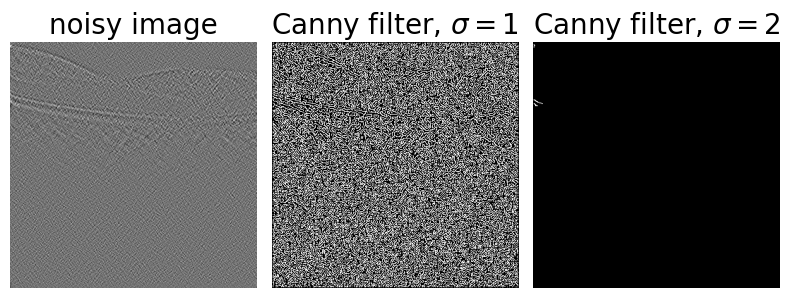

In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.util import random_noise
from skimage import feature

sigma = 0.33

img = cv2.imread('retina2/172.bmp')

# smooth = cv2.imread('sample_172_201_Nwindow30.bmp')
# smooth = cv2.imread('viz_outputs/retina2_ksize1_tavg5_172-176.bmp')
# smooth = cv2.imread('viz_outputs/retina2_ksize1_tavg10_172-181.bmp')

# Temporal Averaging
smooth = cv2.imread('viz_outputs/retina2_ksize1_tavg15_172-186.bmp')
gray = cv2.cvtColor(smooth,cv2.COLOR_BGR2GRAY)

gx = ndi.gaussian_filter(gray, sigma=0.5, order=[0,1], output=np.float64, mode='nearest')
gy = ndi.gaussian_filter(gray, sigma=0.5, order=[1,0], output=np.float64, mode='nearest')

# Conversion of Cartesian coordinates to polar 
mag, ang = cv2.cartToPolar(gx, gy, angleInDegrees = True)
    
# setting the minimum and maximum thresholds 
# for double thresholding
mag_max = np.max(mag)
if not weak_th:
    weak_th = mag_max * 0.1
if not strong_th:strong_th = mag_max * 0.5
    
# getting the dimensions of the input image  
height, width = img.shape
    
# Looping through every pixel of the grayscale 
# image
for i_x in range(width):
    for i_y in range(height):
            
        grad_ang = ang[i_y, i_x]
        grad_ang = abs(grad_ang-180) if abs(grad_ang)>180 else abs(grad_ang)
            
        # selecting the neighbours of the target pixel
        # according to the gradient direction
        # In the x axis direction
        if grad_ang<= 22.5:
            neighb_1_x, neighb_1_y = i_x-1, i_y
            neighb_2_x, neighb_2_y = i_x + 1, i_y
            
        # top right (diagonal-1) direction
        elif grad_ang>22.5 and grad_ang<=(22.5 + 45):
            neighb_1_x, neighb_1_y = i_x-1, i_y-1
            neighb_2_x, neighb_2_y = i_x + 1, i_y + 1
            
        # In y-axis direction
        elif grad_ang>(22.5 + 45) and grad_ang<=(22.5 + 90):
            neighb_1_x, neighb_1_y = i_x, i_y-1
            neighb_2_x, neighb_2_y = i_x, i_y + 1
            
        # top left (diagonal-2) direction
        elif grad_ang>(22.5 + 90) and grad_ang<=(22.5 + 135):
            neighb_1_x, neighb_1_y = i_x-1, i_y + 1
            neighb_2_x, neighb_2_y = i_x + 1, i_y-1
            
        # Now it restarts the cycle
        elif grad_ang>(22.5 + 135) and grad_ang<=(22.5 + 180):
            neighb_1_x, neighb_1_y = i_x-1, i_y
            neighb_2_x, neighb_2_y = i_x + 1, i_y
            
        # Non-maximum suppression step
        if width>neighb_1_x>= 0 and height>neighb_1_y>= 0:
            if mag[i_y, i_x]<mag[neighb_1_y, neighb_1_x]:
                mag[i_y, i_x]= 0
                continue

        if width>neighb_2_x>= 0 and height>neighb_2_y>= 0:
            if mag[i_y, i_x]<mag[neighb_2_y, neighb_2_x]:
                mag[i_y, i_x]= 0

weak_ids = np.zeros_like(img)
strong_ids = np.zeros_like(img)              
ids = np.zeros_like(img)
    
# double thresholding step
for i_x in range(width):
    for i_y in range(height):
            
        grad_mag = mag[i_y, i_x]
            
        if grad_mag<weak_th:
            mag[i_y, i_x]= 0
        elif strong_th>grad_mag>= weak_th:
            ids[i_y, i_x]= 1
        else:
            ids[i_y, i_x]= 2
    
    
# finally returning the magnitude of
# gradients of edges
return mag
   
frame = cv2.imread('food.jpeg')
  
# calling the designed function for
# finding edges
canny_img = Canny_detector(frame)
   
# Displaying the input and output image  
plt.figure()
f, plots = plt.subplots(2, 1) 
plots[0].imshow(frame)
plots[1].imshow(canny_img)


In [ ]:
edges1 = feature.canny(image, 1, 0.05, 0.15)
edges2 = feature.canny(image, 2, 2.5, 3.5)

# display results
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('noisy image', fontsize=20)

ax[1].imshow(edges1, cmap='gray')
ax[1].set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax[2].imshow(edges2, cmap='gray')
ax[2].set_title(r'Canny filter, $\sigma=2$', fontsize=20)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

In [173]:
import cv2
import numpy as np

sigma = 0.33

img = cv2.imread('retina2/172.bmp')
# gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# smooth = cv2.imread('sample_172_201_Nwindow30.bmp')
# smooth = cv2.imread('viz_outputs/retina2_ksize1_tavg5_172-176.bmp')
# smooth = cv2.imread('viz_outputs/retina2_ksize1_tavg10_172-181.bmp')
smooth = cv2.imread('viz_outputs/retina2_ksize1_tavg15_172-186.bmp')

log_ir = np.log(smooth+1)
v_min = log_ir.min()
v_max = log_ir.max()
print(v_min, v_max)

smooth = ((log_ir/v_min)*255).astype(np.uint8)
cv2.imwrite('viz_outputs/log.png', smooth)

sobelX = cv2.Sobel(smooth, cv2.CV_64F, 1, 0)
sobelY = cv2.Sobel(smooth, cv2.CV_64F, 0, 1)
sobelX = np.uint8(np.absolute(sobelX))
sobelY = np.uint8(np.absolute(sobelY))
sobelCombined = cv2.bitwise_or(sobelX, sobelY)

# auto canny
v = np.median(smooth)
# apply automatic Canny edge detection using the computed median
lower = int(max(0, (1.0 - sigma) * v))
upper = int(min(255, (1.0 + sigma) * v))

# canny = cv2.Canny(smooth, lower, upper, 7)
print(lower, upper)
canny = cv2.Canny(smooth, 110, 300, 3)
canny = np.repeat(np.expand_dims(canny, axis=2), 3, axis=2)
canny = canny * (0.5, 0.5, 1.0)

cv2.imwrite('viz_outputs/blur.png', smooth)
cv2.imwrite('viz_outputs/canny.png', canny)
cv2.imwrite('viz_outputs/sobel.png', sobelCombined)

1.099 5.188
105 210


True

In [10]:
dest = cv2.Laplacian(smooth, cv2.CV_16S, ksize=3)
abs_dest = cv2.convertScaleAbs(dest)
cv2.imwrite('viz_outputs/laplacian.png', abs_dest)

True